In [1]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [2]:
api = wandb.Api()

In [18]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [19]:
env = "HalfCheetah-v2"
group_and_keys = [
    ("xppo-512-5", "global_step", "rollout/ep_rew_mean"),
    ("no-reset-512-5", "global_step", "rollout/ep_rew_mean"),
    ("one-phase-512-5", "global_step", "rollout/ep_rew_mean"),
    ("mean-kl-target-512-5", "global_step", "rollout/ep_rew_mean"),
#     ("no-historic-512-5", "global_step", "rollout/ep_rew_mean"),
#     ("second-loop-vf-512-5", "global_step", "rollout/ep_rew_mean"),
]
relabels = {
    "xppo-512-5": "xPPO",
    "no-reset-512-5": "no-reset",
    "one-phase-512-5": "one-phase",
    "mean-kl-target-512-5": "mean-kl-target",
    "no-historic-512-5": "no-historic",
    "second-loop-vf-512-5": "second-loop-vf",
    "baseline_ppo": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"state": "finished"}, {"state": "running"}]},
        ]
    },
)

Got 8 runs for group xppo-512-5
Got 8 runs for group no-reset-512-5
Got 8 runs for group one-phase-512-5
Got 8 runs for group mean-kl-target-512-5


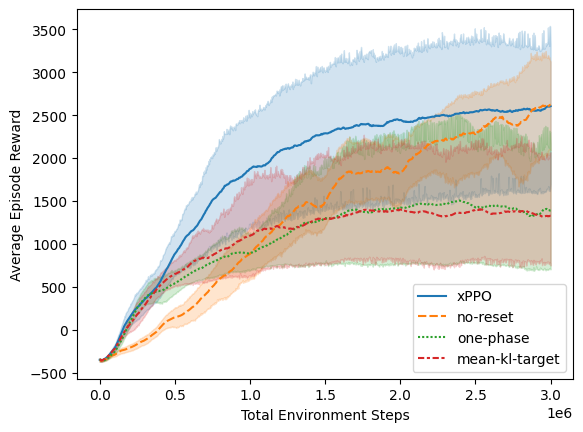

In [20]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
#     palette="viridis",
)
plt.legend(loc="lower right")
plt.savefig(f"xppo_ablations_{env}.pdf")

Got 8 runs for group xppo-512-5
Got 8 runs for group no-reset-512-5
Got 8 runs for group one-phase-512-5
Got 8 runs for group mean-kl-target-512-5


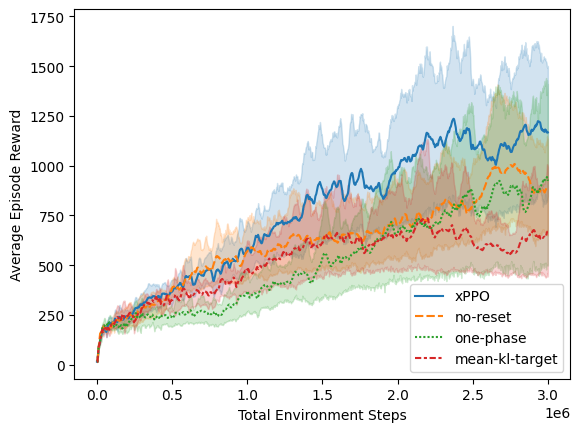

In [16]:
env = "Hopper-v2"
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"state": "finished"}, {"state": "running"}]},
        ]
    },
)
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
#     palette="viridis",
)
plt.legend(loc="lower right")
plt.savefig(f"xppo_ablations_{env}.pdf")

Got 8 runs for group xppo-512-5
Got 8 runs for group no-reset-512-5
Got 8 runs for group one-phase-512-5
Got 8 runs for group mean-kl-target-512-5


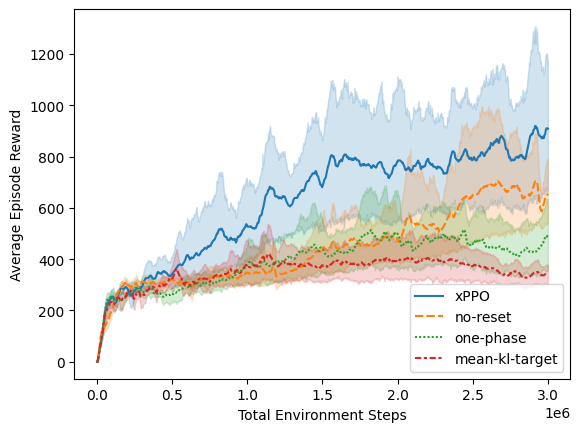

In [17]:
env = "Walker2d-v2"
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"state": "finished"}, {"state": "running"}]},
        ]
    },
)
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
#     palette="viridis",
)
plt.legend(loc="lower right")
plt.savefig(f"xppo_ablations_{env}.pdf")